## Árvores de regressão - exercícios 02

Este exercício será uma continuação do anterior, mesma base, mesmas variáveis - vamos tentar buscar a 'melhor árvore'.


*Atenção - Utilizar a base de dados em anexo que é a mesma base que utilizamos na atividade anterior! A base Boston, assim como para a primeira atividade foi descontinuada e não deve ser utilizada*

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from joblib import Parallel, delayed
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [2]:
df = pd.read_csv('housing.csv')  

### 1. Execute os passos do exercício anterior, até que você tenha uma árvore de regressão predizendo o valor do imóvel na base de treinamento.

In [3]:
# preparar dados (assumindo df já carregado)
if 'ocean_proximity' in df.columns:
    df = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=True).copy()

# separar X e y
target = 'median_house_value'
X = df.drop(columns=[target])
y = df[target]

# preencher missings numéricos sem atribuição encadeada
num_cols = X.select_dtypes(include=['number']).columns
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

# dividir em treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# treinar árvore de regressão (modelo final para a pergunta 1)
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

# confirmar com algumas previsões no conjunto de treino
print("Modelo treinado. Previsões exemplo (treino):", tree_reg.predict(X_train.iloc[:5]).round(2))

Modelo treinado. Previsões exemplo (treino): [103000. 382100. 172600.  93400.  96500.]


### 2.  Calcule o caminho indicado pelos CCP-alfas dessa árvore.

In [4]:
from sklearn.tree import DecisionTreeRegressor

# calcular caminho de poda por custo (CCP)
path = tree_reg.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

# exibir alfas e impurezas
print("CCP alphas:", ccp_alphas)
print("Impurities:", impurities)

# opcional: treinar uma árvore para cada alpha e mostrar número de nós e profundidade
clfs = []
for alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

for alpha, clf in zip(ccp_alphas, clfs):
    print(f"alpha={alpha:.6f}  nodes={clf.tree_.node_count}  depth={clf.tree_.max_depth}")

CCP alphas: [0.00000000e+00 2.52335571e-05 3.02810078e-05 ... 7.44333012e+08
 1.67533461e+09 4.23754184e+09]
Impurities: [0.00000000e+00 5.04671141e-05 8.07481219e-05 ... 7.45490567e+09
 9.13024028e+09 1.33677821e+10]



KeyboardInterrupt



### 3. Paca cada valor de alpha obtido no item 2, treine uma árvore com o respectivo alfa, e guarde essa árvore em uma lista.

In [9]:
# mostra progresso e guarda as árvores em `trees_by_alpha`.
from tqdm.notebook import tqdm

# garantir que ccp_alphas exista
if 'ccp_alphas' not in globals():
    path = tree_reg.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas = path.ccp_alphas

# preparar alfas: únicos, remover quase-zero e limitar quantidade
alphas = np.unique(ccp_alphas)
alphas = alphas[alphas > 1e-12]        # filtra alfas praticamente zero
max_trees = 50                         # ajuste este número se quiser mais/menos
if len(alphas) > max_trees:
    alphas = np.linspace(alphas.min(), alphas.max(), max_trees)

# treinar sequencialmente com barra de progresso
trees_by_alpha = []
for a in tqdm(alphas, desc="Treinando árvores por alpha"):
    clf = DecisionTreeRegressor(random_state=42, ccp_alpha=float(a))
    clf.fit(X_train, y_train)
    trees_by_alpha.append(clf)

# resultado
print(f"Treinadas {len(trees_by_alpha)} árvores. Lista: trees_by_alpha")


Treinando árvores por alpha:   0%|          | 0/50 [00:00<?, ?it/s]

Treinadas 50 árvores. Lista: trees_by_alpha


### 4. Para cada árvore na lista, calcule o MSE da árvore.

In [11]:
from sklearn.metrics import mean_squared_error

if 'trees_by_alpha' not in globals():
    raise RuntimeError("Lista 'trees_by_alpha' não encontrada. Execute o passo 3 primeiro.")

# calcular MSE no conjunto de treino
mse_train = [mean_squared_error(y_train, clf.predict(X_train)) for clf in trees_by_alpha]

# calcular MSE no conjunto de teste se existir
mse_test = None
if 'X_test' in globals() and 'y_test' in globals():
    mse_test = [mean_squared_error(y_test, clf.predict(X_test)) for clf in trees_by_alpha]

# obter alfas usados
if 'alphas' in globals():
    alphas_used = np.array(alphas)[:len(trees_by_alpha)]
else:
    alphas_used = np.array([getattr(clf, "ccp_alpha", None) for clf in trees_by_alpha])

# montar DataFrame resumo
summary = pd.DataFrame({
    'alpha': alphas_used,
    'mse_train': mse_train
})
if mse_test is not None:
    summary['mse_test'] = mse_test

display(summary.reset_index(drop=True))

,alpha,mse_train,mse_test
0,2.523356e-05,5.046835e-05,4.865869e+09
1,8.648045e+07,5.195039e+09,5.258927e+09
2,1.729609e+08,5.621826e+09,5.789036e+09
3,2.594413e+08,6.172284e+09,6.332199e+09
4,3.459218e+08,6.172284e+09,6.332199e+09
5,4.324022e+08,6.172284e+09,6.332199e+09
6,5.188827e+08,6.172284e+09,6.332199e+09
7,6.053631e+08,6.710573e+09,6.893608e+09
8,6.918436e+08,6.710573e+09,6.893608e+09
9,7.783240e+08,7.454906e+09,7.574226e+09


### 5. Monte um gráfico do MSE pelo alpha, escolha um valor de alpha perto do ponto de mínimo do MSE

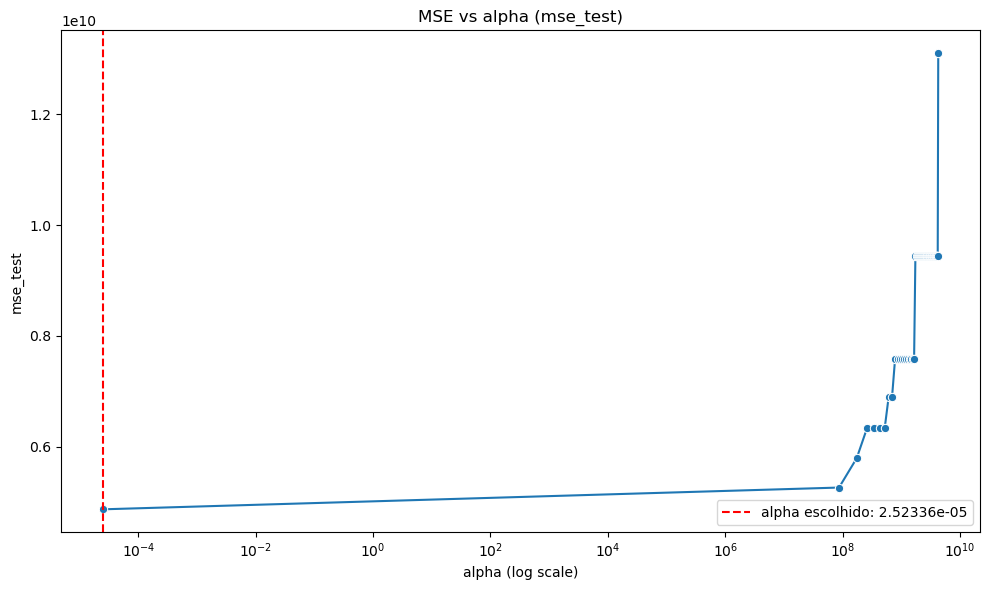

2.5233557057935137e-05


In [14]:
# garantir que exista o DataFrame summary; se não, recalcular
if 'summary' not in globals():
    if 'trees_by_alpha' not in globals():
        raise RuntimeError("Lista 'trees_by_alpha' não encontrada. Execute o passo 3 primeiro.")
    alphas_used = np.array([getattr(clf, "ccp_alpha", None) for clf in trees_by_alpha], dtype=float)
    mse_train = [mean_squared_error(y_train, clf.predict(X_train)) for clf in trees_by_alpha]
    mse_test = None
    if 'X_test' in globals() and 'y_test' in globals():
        mse_test = [mean_squared_error(y_test, clf.predict(X_test)) for clf in trees_by_alpha]
    summary = pd.DataFrame({'alpha': alphas_used, 'mse_train': mse_train})
    if mse_test is not None:
        summary['mse_test'] = mse_test

# escolher coluna de MSE
mse_col = 'mse_test' if 'mse_test' in summary.columns else 'mse_train'

# filtrar alfas positivos para escala log (remover zeros ou negativos)
summary = summary.copy()
summary['alpha'] = summary['alpha'].astype(float)
summary = summary[summary['alpha'] > 0].reset_index(drop=True)

# ordenar por alpha para plot mais limpo
summary = summary.sort_values('alpha').reset_index(drop=True)
x = summary['alpha'].astype(float)
y = summary[mse_col].astype(float)

# plot MSE vs alpha (escala log no eixo x)
plt.figure(figsize=(10,6))
sns.lineplot(x=x, y=y, marker='o')
plt.xscale('log')
plt.xlabel('alpha (log scale)')
plt.ylabel(mse_col)
plt.title(f'MSE vs alpha ({mse_col})')

# encontrar índice do mínimo e escolher um alpha próximo (índice anterior se existir)
idx_min = y.idxmin()
idx_near = idx_min-1 if idx_min-1 >= 0 else idx_min
alpha_near = float(summary.loc[idx_near, 'alpha'])

# marcar no gráfico
plt.axvline(alpha_near, color='red', linestyle='--', label=f'alpha escolhido: {alpha_near:.6g}')
plt.legend()
plt.tight_layout()
plt.show()

# imprimir alpha escolhido
print(alpha_near)


### 6. Calcule o R-quadrado dessa árvore encontrada no item acima

In [15]:
from sklearn.metrics import r2_score

# garantir que exista a lista de árvores
if 'trees_by_alpha' not in globals():
    raise RuntimeError("Lista 'trees_by_alpha' não encontrada. Execute o passo 3 primeiro.")

# determinar alpha escolhido (usar alpha_near se existir, senão tentar extrair do summary)
if 'alpha_near' in globals():
    chosen_alpha = float(alpha_near)
else:
    if 'summary' in globals():
        mse_col = 'mse_test' if 'mse_test' in summary.columns else 'mse_train'
        idx_min = summary[mse_col].idxmin()
        chosen_alpha = float(summary.loc[idx_min, 'alpha'])
    else:
        # fallback: usar o menor alpha disponível
        alphas_arr = np.array([getattr(clf, "ccp_alpha", np.nan) for clf in trees_by_alpha], dtype=float)
        chosen_alpha = float(np.nanmin(alphas_arr))

# localizar a árvore cujo ccp_alpha é mais próxima do alpha escolhido
alphas_arr = np.array([getattr(clf, "ccp_alpha", np.nan) for clf in trees_by_alpha], dtype=float)
idx_closest = int(np.nanargmin(np.abs(alphas_arr - chosen_alpha)))
best_tree = trees_by_alpha[idx_closest]

# calcular R^2 (usar teste se disponível, senão treino)
if 'X_test' in globals() and 'y_test' in globals():
    r2 = r2_score(y_test, best_tree.predict(X_test))
    dataset = 'test'
else:
    r2 = r2_score(y_train, best_tree.predict(X_train))
    dataset = 'train'

print(f"chosen_alpha={chosen_alpha}")
print(f"closest_alpha_in_list={alphas_arr[idx_closest]}")
print(f"tree_index={idx_closest}  dataset={dataset}  r2={r2}")

chosen_alpha=2.5233557057935137e-05
closest_alpha_in_list=2.5233557057935137e-05
tree_index=0  dataset=test  r2=0.628675557191997


### 7. Visualize esta árvore.

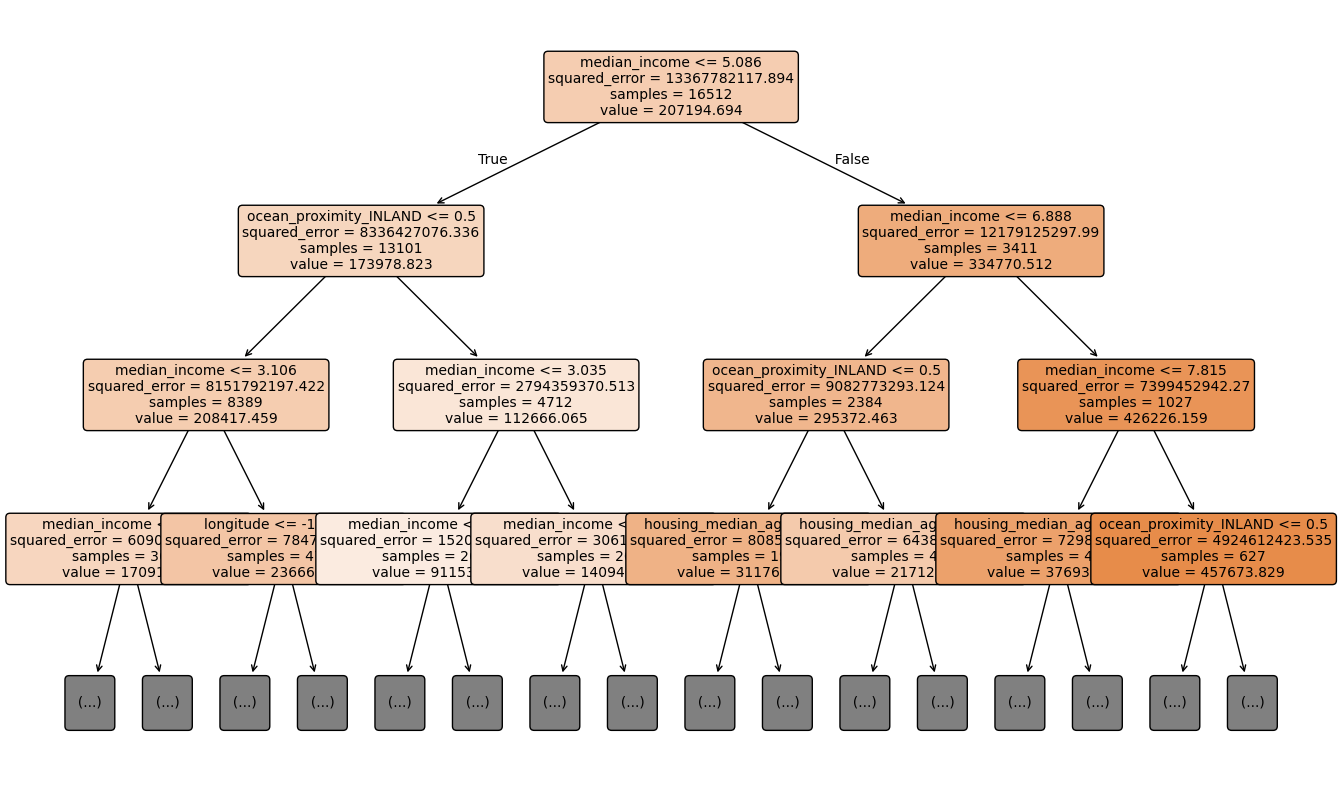

In [21]:
# localizar a árvore escolhida (usa best_tree se existir)
if 'best_tree' in globals():
    clf = best_tree
else:
    if 'alpha_near' in globals():
        chosen_alpha = float(alpha_near)
    elif 'summary' in globals():
        mse_col = 'mse_test' if 'mse_test' in summary.columns else 'mse_train'
        idx_min = summary[mse_col].idxmin()
        chosen_alpha = float(summary.loc[idx_min, 'alpha'])
    else:
        alphas_arr = np.array([getattr(c, "ccp_alpha", np.nan) for c in trees_by_alpha], dtype=float)
        chosen_alpha = float(np.nanmin(alphas_arr))
    alphas_arr = np.array([getattr(c, "ccp_alpha", np.nan) for c in trees_by_alpha], dtype=float)
    idx_closest = int(np.nanargmin(np.abs(alphas_arr - chosen_alpha)))
    clf = trees_by_alpha[idx_closest]

# plotar árvore limitada em profundidade para visualização rápida
plt.figure(figsize=(16,10))
tree.plot_tree(
    clf,
    feature_names=(X_train.columns if hasattr(X_train, "columns") else None),
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3  # ajuste este valor para mostrar mais/menos níveis
)
plt.show()